In [2]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
from cmcrameri import cm as cmc

from utils import integrated_zonal_momentum_terms, load_config, default_params, axes_styling, calculate_bathymetry

In [3]:
config = "slope-200"

ds = xr.open_dataset("../output/"+config+".nc").squeeze()
params = load_config("../configs/"+config+".json", default_params)
ds

<xarray.Dataset>
Dimensions:       (xC: 120, yF: 90, xF: 121, yC: 90, time: 1025)
Coordinates:
    zC            float64 0.0
    zF            float64 0.0
  * xC            (xC) float64 500.0 1.5e+03 2.5e+03 ... 1.185e+05 1.195e+05
  * yF            (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * xF            (xF) float64 0.0 1e+03 2e+03 ... 1.18e+05 1.19e+05 1.2e+05
  * yC            (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.85e+04 8.95e+04
  * time          (time) timedelta64[ns] 0 days 00:00:00 ... 128 days 00:00:00
Data variables:
    v             (time, yF, xC) float64 ...
    omegav        (time, yF, xF) float64 ...
    duvhdx        (time, yC, xC) float64 ...
    omega         (time, yF, xF) float64 ...
    omegau        (time, yF, xF) float64 ...
    divomegaflux  (time, yF, xC) float64 ...
    u             (time, yC, xF) float64 ...
    h             (time, yC, xC) float64 ...
    detady        (time, yF, xC) float64 ...
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.91.14
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-03-18T17:24:58.949.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

In [4]:
tau = xr.open_dataset("../../"+params["forcing_file"]).squeeze()
tau

<xarray.Dataset>
Dimensions:    (time: 1024, x: 120, y: 90)
Coordinates:
  * time       (time) float64 0.0 1.08e+04 2.16e+04 ... 1.104e+07 1.105e+07
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 1.17e+05 1.18e+05 1.19e+05
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
Data variables:
    forcing_x  (time, x, y) float64 ...
    forcing_y  (time, x, y) float64 ...

In [5]:
xidx = 45
terms = integrated_zonal_momentum_terms(params, ds, xidx)
terms = terms.drop("formstress")
terms["surfstress"][1:] = tau.forcing_y.isel(x=xidx).mean("y").values/1000

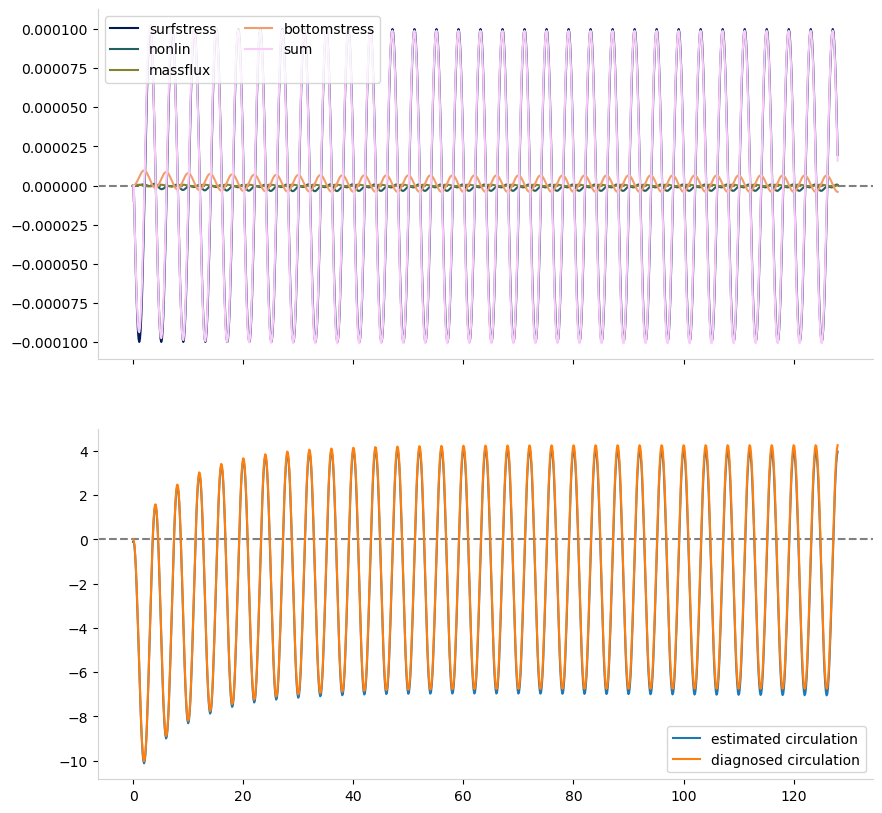

In [6]:
fig, [ax, ax2] = plt.subplots(figsize=(10,10), nrows=2, sharex=True)
axes_styling(ax)
axes_styling(ax2)
ax.axhline(0, color="gray", ls="--")
ax2.axhline(0, color="gray", ls="--")

terms["sum"] = terms["surfstress"] + terms["nonlin"] + terms["massflux"] + terms["bottomstress"]

tday = terms.time / np.timedelta64(1,"D")

colors = cmc.batlow(np.linspace(0, 1, len(terms)))
for term, color in zip(terms, colors):
    ax.plot(tday, -terms[term], label=term, color=color)
    
circ_est = (terms["sum"]*params["outputtime"]).cumsum("time")
circ_diag = (ds.v.isel(xC=xidx)*calculate_bathymetry(ds.xC.isel(xC=xidx), ds.yF, params)).mean("yF")


ax2.plot(tday, -circ_est, label = "estimated circulation")
ax2.plot(tday, -circ_diag, label = "diagnosed circulation")

    
ax.legend(ncols=2)
ax2.legend()

#ax2.set_xlim(50,60)
fig.savefig(f"../figures/terms/xcontour/xcontour_terms_ts_{config}.png")

In [7]:
idxs = np.arange(0, 120)
termlist = []
circlist = []
for xidx in idxs:
    terms = integrated_zonal_momentum_terms(params, ds, xidx)
    terms= terms.drop("formstress")
    terms["surfstress"][1:] = tau.forcing_y.isel(x=xidx).mean("y").values/1025
    
    circ = -(ds.v.isel(xC=xidx)*calculate_bathymetry(ds.xC.isel(xC=xidx), ds.yF, params)).mean("yF")
    
    termlist.append(terms)
    circlist.append(circ)
    
    
results = xr.concat(termlist, dim="x")
results["sum"] = results["surfstress"] + results["nonlin"] + results["massflux"] + results["bottomstress"]
circ = xr.concat(circlist, dim="x")

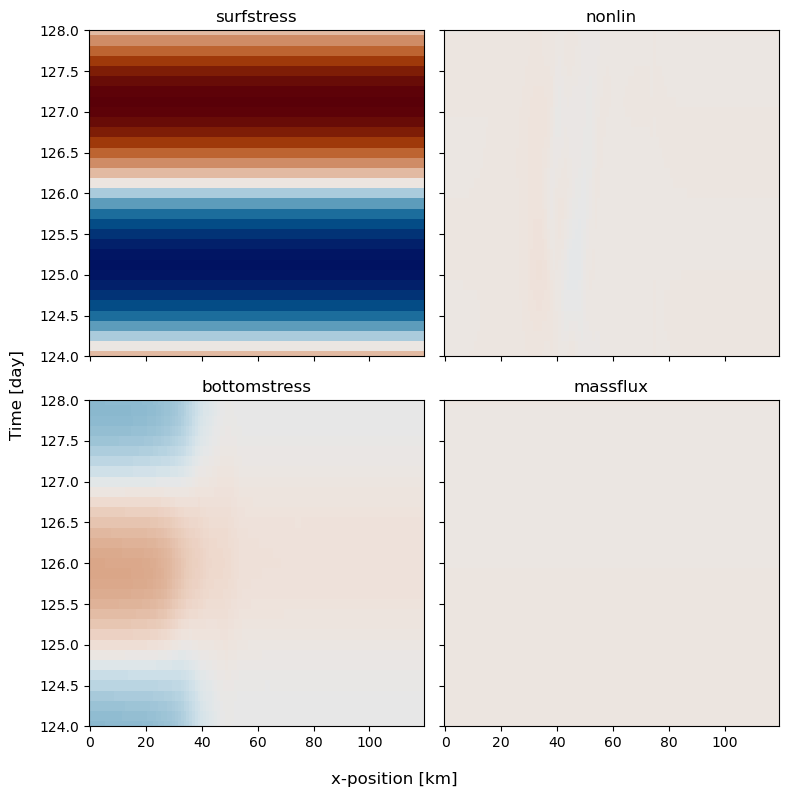

In [8]:
fig, axes = plt.subplots(figsize=(8,8), ncols=2, nrows=2, sharex=True, sharey=True)

vmax = np.max([np.abs(results[term]).quantile(0.98) for term in results])

terms = ["surfstress", "nonlin", "bottomstress", "massflux"]
for term, ax in zip(terms, axes.flatten()):
    ax.pcolormesh(idxs, tday, -results[term].T, vmin=-vmax, vmax=vmax, cmap=cmc.vik)
    ax.set_title(term)
    
fig.supxlabel("x-position [km]")
fig.supylabel("Time [day]")
    
Td = params["T"] / (24*60*60)   
tmaxd = params["tmax"] / (24*60*60)  

ax.set_ylim(tmaxd-Td, tmaxd)
#ax.set_xlim(15, 75)
fig.tight_layout()

fig.savefig(f"../figures/terms/xcontour/xcontour_terms_cm_{config}.png")

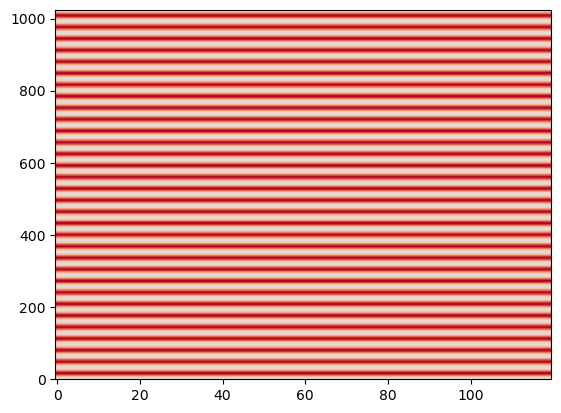

In [9]:
tau = results["surfstress"]

tau = tau.squeeze()
fig, ax = plt.subplots()
cumtau = tau.cumsum("time")
vmax = np.max(np.abs(cumtau))
t = np.arange(0,len(results.time))
ax.pcolormesh(tau.x, t, cumtau.T, vmin=-vmax, vmax=vmax, cmap="coolwarm")

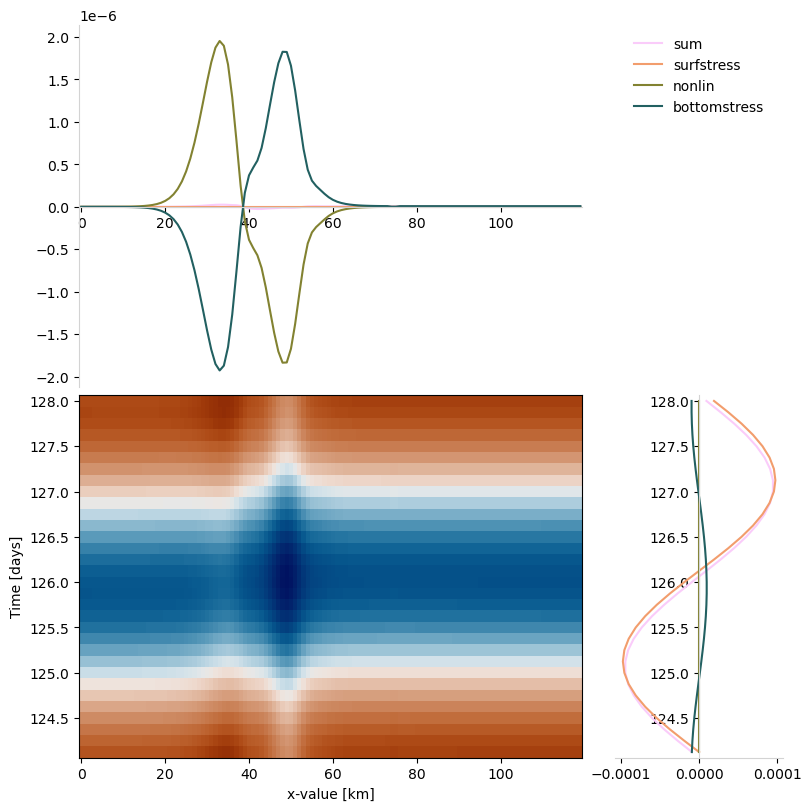

In [10]:
fig = plt.figure(layout="constrained", figsize=(8,8))
axd = fig.subplot_mosaic(
    [
        ["tmean", "legend"],
        ["circ", "xmean"],
    ],
    #empty_sentinel="BLANK",TypeError: Dimensions of C (120, 1025) should be one smaller than X(120) and Y(1025) while using shading='flat' see help(pcolormesh)
    # set the width ratios between the columns
    width_ratios=[3, 1],
)

cmap = cmc.batlow
n = 5
colors = [cmap(1 - i / (n - 1)) for i in range(n)]

axd["tmean"].sharex(axd["circ"])
axd["xmean"].sharey(axd["circ"])

axd["tmean"].spines['right'].set_color('none')  # Remove the right spine
axd["tmean"].spines['top'].set_color('none')  # Remove the top spine
axd["tmean"].spines['bottom'].set_position('zero')  # Set the bottom spine position
axd["tmean"].spines['left'].set_color('lightgray')
axd["tmean"].spines['bottom'].set_color('lightgray')

axd["xmean"].spines['right'].set_color('none')  # Remove the right spine
axd["xmean"].spines['top'].set_color('none')  # Remove the top spine
axd["xmean"].spines['left'].set_position('zero')  # Set the bottom spine position
axd["xmean"].spines['left'].set_color('lightgray')
axd["xmean"].spines['bottom'].set_color('lightgray')

Tn = int(params["T"]/params["outputtime"])

circT = circ.isel(time=slice(-Tn, None))
resultsT = results.isel(time=slice(-Tn, None))
vmax = np.max(np.abs(circT))
axd["circ"].pcolormesh(idxs, tday[-Tn:], circT.T, 
                  vmin=-vmax, vmax=vmax, 
                  cmap=cmc.vik)

axd["circ"].set_xlabel("x-value [km]")
axd["circ"].set_ylabel("Time [days]")

terms = ["sum", "surfstress", "nonlin", "bottomstress"]
for term, color in zip(terms, colors):
    result = -resultsT[term]
    tmean = result.mean("time")
    xmean = result.mean("x")
    
    axd["xmean"].plot(xmean, tday[-Tn:], label=term, color=color)
    axd["tmean"].plot(idxs, tmean, label=term, color=color)
    
    axd["legend"].plot([None, None], [None, None], label=term,color=color)
    
axd["legend"].axis("off")
axd["legend"].legend(loc='upper center', 
                    frameon=False,
                )

fig.savefig(f"../figures/terms/xcontour/xcontour_terms_integrated_{config}.png")